In [11]:
import fipy as fp  ## finite volume PDE solver
from fipy.tools import numerix  ## requirement for FiPy, in practice same as numpy
import copy  ## we need the deepcopy() function because some FiPy objects are mutable
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

## numeric implementation of Dirac delta function as mentioned in the equation above
def delta_func(x, epsilon, coeff):
    return ((x < epsilon) & (x > -epsilon)) * \
        (coeff * (1 + numerix.cos(numerix.pi * x / epsilon)) / (2 * epsilon))

def solve_uniformIC(R_from = 0.7, R_to = 1.0, nr = 1000, duration = 0.001, nt = 1000,
                    conv_file = 'convC.txt', diff_file = 'diffC.txt', 
                    levels = 300, logdiff = 10, ticks = None, figsize=(10,4)):
    
    if ticks == None:
        ticks = logdiff
    else:
        ticks = ticks
    
    ## R_from = inner radius in meters, R_to = outer radius in meters
    ## nr = number of mesh cells
    ## duration = length of examined time evolution in seconds, nt = number of timesteps
    dr = (R_to - R_from) / nr  ## distance between the centers of the mesh cells
    dt = duration / nt  ## length of one timestep

    ## 3D array for storing the density with the correspondant radius values
    ## the density values corresponding to the n-th timestep will be in the n-th line 
    solution = np.zeros((nt,nr,2))
    ## loading the radial coordinates into the array
    for j in range(nr):
        solution[:,j,0] = (j * dr) + (dr / 2) + R_from

    mesh = fp.Grid1D(dx=dr, nx=nr)  ## 1D mesh based on the radial coordinates 
    mesh = mesh + (R_from,)  ## translation of the mesh to R_from
    n = fp.CellVariable(mesh=mesh)  ## fipy.CellVariable for the density solution in each timestep
    n.setValue(1) ## applying initial conditions
    
    ## coefficient data from CSV file
    conv_data = np.genfromtxt(conv_file, delimiter=',')
    diff_data = np.genfromtxt(diff_file, delimiter=',')
    
    ## arrays for interpolated coefficient vales
    conv_i = np.zeros((nr, 2))
    diff_i = np.zeros((nr, 2))
    ## filling up the arrays with spatial coordinates
    for i in range(conv_i.shape[0]):
        conv_i[i, 0] = R_from + (i * dr) + (dr / 2)

    for i in range(diff_i.shape[0]):
        diff_i[i, 0] = R_from + (i * dr) + (dr / 2)

    ## interpolation of the coeficients
    conv_i[:,1] = np.interp(conv_i[:,0],conv_data[:,0],conv_data[:,1])
    diff_i[:,1] = np.interp(diff_i[:,0],diff_data[:,0],diff_data[:,1])

    ## space dependent diffusion coefficient
    dC = diff_i[:,1]
    diffCoeff = fp.CellVariable(mesh=mesh, value=dC)
    ## space dependent convection coefficient - must be a vector
    cC = conv_i[:,1]
    convCoeff = fp.CellVariable(mesh=mesh, value=[cC])
    
    ## boundary conditions
    gradLeft = (0.,)  ## density gradient (at the "left side of the radius") - must be a vector
    valueRight = 0.  ## density value (at the "right end of the radius")
    n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## applying Neumann boundary condition
    n.constrain(valueRight, mesh.facesRight)  ## applying Dirichlet boundary condition
    convCoeff.setValue(0, where=mesh.x<(R_from + dr))  ## convection coefficient 0 at the inner edge
    diffCoeff.setValue(0.001, where=mesh.x<(R_from + dr))  ## diffusion coefficient almost 0 at inner edge

    ## the PDE
    eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
          - fp.ConvectionTerm(coeff=convCoeff))

    ## Solving the PDE and storing the data
    for i in range(nt):
        eq.solve(var=n, dt=dt)
        solution[i,0:nr,1]=copy.deepcopy(n.value)

    ## Logarithmic data plotting with logaritmic time scale (base=10) 
    ## ticks sets the number of ticks on the colorbar (recommendended<=10)
    ## levels sets the number of color levels on the contour plot
    ## logdiff sets the interesting data interval width from the maximum down by 10^logdiff
    sol_min = solution[:,:,1].min()
    sol_max = solution[:,:,1].max()
    logmax = math.ceil(np.log10(sol_max))
    logmin = logmax - logdiff
    numofticks = ticks
    div = logdiff // numofticks
    power = np.arange((logmax - (numofticks * div)), logmax, div)
    array1 = np.zeros(len(power)) + 10.
    ticks1 = np.power(array1, power)
    levels1 = np.logspace(logmin,logmax,levels, base=10.0)
    norm = matplotlib.colors.LogNorm(vmin=(10 ** logmin),vmax=sol_max)
    formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
    fig = plt.figure(figsize=figsize)
    plot = plt.contourf(solution[0,:,0], np.linspace(dt,duration,nt), solution[:,:,1],
                        levels=levels1, norm=norm, cmap=plt.cm.jet)
    axes = plt.gca()
    axes.set_facecolor((0.,0.,0.25)) ## dark blue will display where the values are too small
    axes.set_yscale('log')
    cbar = plt.colorbar(ticks=ticks1, format=formatter)
    cbar.set_label(r'Density (1/m$^3$)')
    plt.xlabel('radius (m)')
    plt.ylabel(r'log$_{10}$[time (s)]')
    plt.title(r'Density of runaway electrons (1/m$^3$)')
    return

def solve_DiracIC(R_from = 0.7, R_to = 1.0, nr = 1000, duration = 0.001, nt = 1000,
                  diracLoc = 0.85, diracCoeff = 1., diracPercentage = 2,
                  conv_file = 'convC.txt', diff_file = 'diffC.txt', 
                  levels = 300, logdiff = 10, ticks = None, figsize=(10,4)):
    
    if ticks == None:
        ticks = logdiff
    else:
        ticks = ticks
    
    ## R_from = inner radius in meters, R_to = outer radius in meters
    ## nr = number of mesh cells
    ## duration = length of examined time evolution in seconds, nt = number of timesteps
    dr = (R_to - R_from) / nr  ## distance between the centers of the mesh cells
    dt = duration / nt  ## length of one timestep

    ## 3D array for storing the density with the correspondant radius values
    ## the density values corresponding to the n-th timestep will be in the n-th line 
    solution = np.zeros((nt,nr,2))
    ## loading the radial coordinates into the array
    for j in range(nr):
        solution[:,j,0] = (j * dr) + (dr / 2) + R_from

    mesh = fp.Grid1D(dx=dr, nx=nr)  ## 1D mesh based on the radial coordinates 
    mesh = mesh + (R_from,)  ## translation of the mesh to R_from
    n = fp.CellVariable(mesh=mesh)  ## fipy.CellVariable for the density solution in each timestep
    
    # diracLoc = location of the middle of the Dirac delta
    # diracCoeff = Dirac delta coefficient ("height")
    # diracPercentage = width of Dirac delta (full width from 0 to 0) in percentage of full examined radius
    diracWidth = int((nr / 100) * diracPercentage)
    
    ## applying initial conditions
    n.setValue(delta_func(mesh.x - diracLoc, diracWidth * dr, diracCoeff))
    
    ## transport coefficient data from CSV file
    conv_data = np.genfromtxt(conv_file, delimiter=',')
    diff_data = np.genfromtxt(diff_file, delimiter=',')
    
    ## arrays for interpolated coefficient vales
    conv_i = np.zeros((nr, 2))
    diff_i = np.zeros((nr, 2))
    ## filling up the arrays with spatial coordinates
    for i in range(conv_i.shape[0]):
        conv_i[i, 0] = R_from + (i * dr) + (dr / 2)

    for i in range(diff_i.shape[0]):
        diff_i[i, 0] = R_from + (i * dr) + (dr / 2)

    ## interpolation of the coeficients
    conv_i[:,1] = np.interp(conv_i[:,0],conv_data[:,0],conv_data[:,1])
    diff_i[:,1] = np.interp(diff_i[:,0],diff_data[:,0],diff_data[:,1])

    ## space dependent diffusion coefficient
    dC = diff_i[:,1]
    diffCoeff = fp.CellVariable(mesh=mesh, value=dC)
    ## space dependent convection coefficient - must be a vector
    cC = conv_i[:,1]
    convCoeff = fp.CellVariable(mesh=mesh, value=[cC])
    
    ## boundary conditions
    gradLeft = (0.,)  ## density gradient (at the "left side of the radius") - must be a vector
    valueRight = 0.  ## density value (at the "right end of the radius")
    n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## applying Neumann boundary condition
    n.constrain(valueRight, mesh.facesRight)  ## applying Dirichlet boundary condition
    convCoeff.setValue(0, where=mesh.x<(R_from + dr))  ## convection coefficient 0 at the inner edge
    diffCoeff.setValue(0.001, where=mesh.x<(R_from + dr))  ## diffusion coefficient almost 0 at inner edge

    ## the PDE
    eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
          - fp.ConvectionTerm(coeff=convCoeff))

    ## Solving the PDE and storing the data
    for i in range(nt):
        eq.solve(var=n, dt=dt)
        solution[i,0:nr,1]=copy.deepcopy(n.value)

    ## Logarithmic data plotting with logaritmic time scale (base=10) 
    ## ticks sets the number of ticks on the colorbar (recommendended<=10)
    ## levels sets the number of color levels on the contour plot
    ## logdiff sets the interesting data interval width from the maximum down by 10^logdiff
    sol_min = solution[:,:,1].min()
    sol_max = solution[:,:,1].max()
    logmax = math.ceil(np.log10(sol_max))
    logmin = logmax - logdiff
    numofticks = ticks
    div = logdiff // numofticks
    power = np.arange((logmax - (numofticks * div)), logmax, div)
    array1 = np.zeros(len(power)) + 10.
    ticks1 = np.power(array1, power)
    levels1 = np.logspace(logmin,logmax,levels, base=10.0)
    norm = matplotlib.colors.LogNorm(vmin=(10 ** logmin),vmax=sol_max)
    formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
    fig = plt.figure(figsize=figsize)
    plot = plt.contourf(solution[0,:,0], np.linspace(dt,duration,nt), solution[:,:,1],
                        levels=levels1, norm=norm, cmap=plt.cm.jet)
    axes = plt.gca()
    axes.set_facecolor((0.,0.,0.25)) ## dark blue will display where the values are too small
    axes.set_yscale('log')
    cbar = plt.colorbar(ticks=ticks1, format=formatter)
    cbar.set_label(r'Density (1/m$^3$)')
    plt.xlabel('radius (m)')
    plt.ylabel(r'log$_{10}$[time (s)]')
    plt.title(r'Density of runaway electrons (1/m$^3$)')
    return

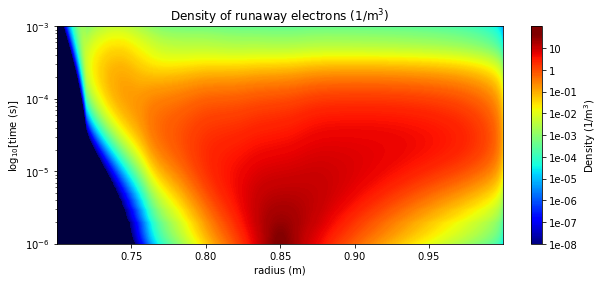

In [14]:
# def solve_DiracIC(R_from = 0.7, R_to = 1.0, nr = 1000, duration = 0.001, nt = 1000,
#                   diracLoc = 0.85, diracCoeff = 1., diracPercentage = 2,
#                   conv_file = 'convC.txt', diff_file = 'diffC.txt', 
#                   levels = 300, logdiff = 10, ticks = None, figsize=(10,4))
solve_DiracIC()

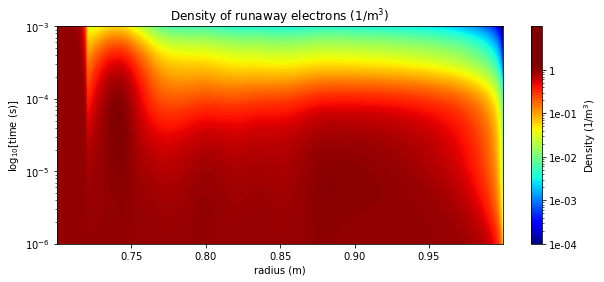

In [9]:
# def solve_uniformIC(R_from = 0.7, R_to = 1.0, nr = 1000, duration = 0.001, nt = 1000,
#                     conv_file = 'convC.txt', diff_file = 'diffC.txt', 
#                     levels = 300, logdiff = 10, ticks = None, figsize=(10,4))
solve_uniformIC(logdiff = 5)